<a href="https://colab.research.google.com/github/Tharuka606/book_recommendation/blob/main/fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2025-04-04 13:02:34--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  --.-KB/s    in 0.1s    

2025-04-04 13:02:34 (183 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [3]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [4]:
# Filter users with 200+ ratings and books with 100+ ratings
user_counts = df_ratings['user'].value_counts()
book_counts = df_ratings['isbn'].value_counts()

ratings_filtered = df_ratings[
    (df_ratings['user'].isin(user_counts[user_counts >= 200].index)) &
    (df_ratings['isbn'].isin(book_counts[book_counts >= 100].index))
]

# Merge books and ratings data
merged_df = ratings_filtered.merge(df_books, on='isbn')

# Pivot table creation (books as rows, users as columns)
book_user_matrix = merged_df.pivot_table(
    index='title',
    columns='user',
    values='rating'
).fillna(0)

# Check shape
print(book_user_matrix.shape)

(673, 888)


In [5]:
# Convert the pivot table to a sparse matrix format
book_sparse_matrix = csr_matrix(book_user_matrix.values)

# Initialize and train the NearestNeighbors model
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(book_sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [8]:
# function to return recommended books - this will be tested
def get_recommends(book=""):
    recommended_books = []

    if book not in book_user_matrix.index:
        return f"Book '{book}' not found in the dataset."

    book_idx = book_user_matrix.index.get_loc(book)
    distances, indices = model.kneighbors(book_user_matrix.iloc[book_idx,:].values.reshape(1, -1), n_neighbors=6)

    # Reverse the order to match expected output
    for i in range(len(distances.flatten())-1, 0, -1):
        recommended_books.append([
            book_user_matrix.index[indices.flatten()[i]],
            distances.flatten()[i]
        ])

    return [book, recommended_books]

In [9]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", np.float32(0.8016211)], ['The Weight of Water', np.float32(0.77085835)], ['The Surgeon', np.float32(0.7699411)], ['I Know This Much Is True', np.float32(0.7677075)], ['The Lovely Bones: A Novel', np.float32(0.7234864)]]]
You passed the challenge! 🎉🎉🎉🎉🎉


<ipython-input-12-994cf7eb6b5e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=distances, y=recommended_books, palette="viridis")


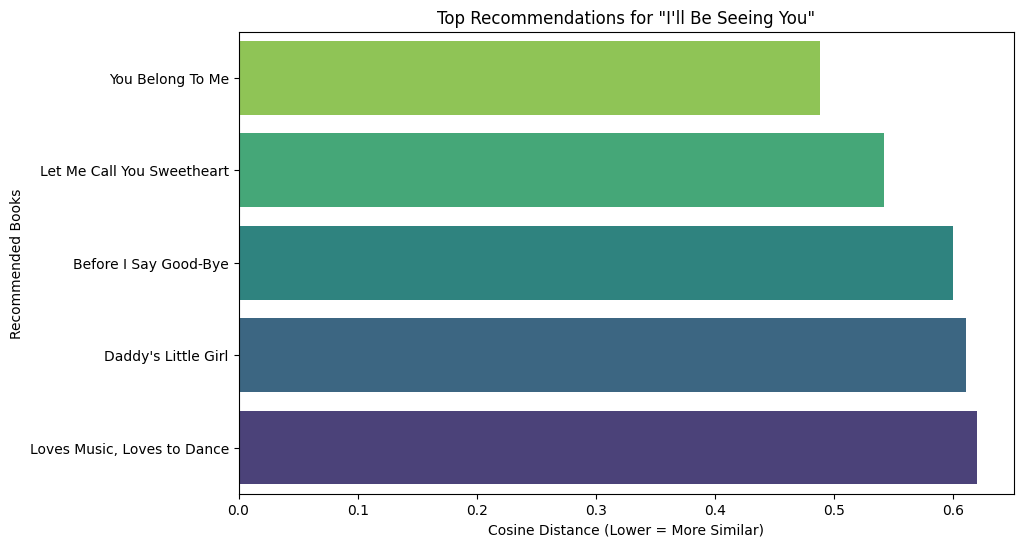

In [12]:
# visualize the similarity between books

import seaborn as sns

# Choose a book to visualize recommendations for
book_title = "I'll Be Seeing You"

# Get recommendations
recommendations = get_recommends(book_title)

# Extract recommended book titles and distances
recommended_books = [rec[0] for rec in recommendations[1]]
distances = [rec[1] for rec in recommendations[1]]

# Plotting
plt.figure(figsize=(10,6))
sns.barplot(x=distances, y=recommended_books, palette="viridis")
plt.xlabel('Cosine Distance (Lower = More Similar)')
plt.ylabel('Recommended Books')
plt.title(f'Top Recommendations for "{book_title}"')
plt.gca().invert_yaxis()  # Highest similarity at the top
plt.show()
